In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import _pickle as cPickle
import queue as Q
vocab = cPickle.load(open('dataset/text/vocab.pkl', 'rb'))
print('total {} vocabularies'.format(len(vocab)))

/users/student/mr105/wuhoward/DeepLearning/.env/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


total 26900 vocabularies


In [2]:
def count_vocab_occurance(vocab, df):
    voc_cnt = {v: 0 for v in vocab}
    for img_id, row in df.iterrows():
        for w in row['caption'].split(' '):
            voc_cnt[w] += 1
    return voc_cnt


df_train = pd.read_csv(os.path.join('dataset', 'train.csv'))

print('count vocabulary occurances...')
voc_cnt = count_vocab_occurance(vocab, df_train)

# remove words appear < 50 times
thrhd = 50
x = np.array(list(voc_cnt.values()))
print('{} words appear >= 50 times'.format(np.sum(x[(-x).argsort()] >= thrhd)))

count vocabulary occurances...
3153 words appear >= 50 times


In [3]:
def build_voc_mapping(voc_cnt, thrhd):
    """
    enc_map: voc --encode--> id
    dec_map: id --decode--> voc
    """

    def add(enc_map, dec_map, voc):
        enc_map[voc] = len(dec_map)
        dec_map[len(dec_map)] = voc
        return enc_map, dec_map

    # add <ST>, <ED>, <RARE>
    enc_map, dec_map = {}, {}
    for voc in ['<ST>', '<ED>', '<RARE>']:
        enc_map, dec_map = add(enc_map, dec_map, voc)
    for voc, cnt in voc_cnt.items():
        if cnt < thrhd:  # rare words => <RARE>
            enc_map[voc] = enc_map['<RARE>']
        else:
            enc_map, dec_map = add(enc_map, dec_map, voc)
    return enc_map, dec_map


enc_map, dec_map = build_voc_mapping(voc_cnt, thrhd)
# save enc/decoding map to disk
cPickle.dump(enc_map, open('dataset/text/enc_map.pkl', 'wb'))
cPickle.dump(dec_map, open('dataset/text/dec_map.pkl', 'wb'))

In [4]:
def caption_to_ids(enc_map, df):
    img_ids, caps = [], []
    for idx, row in df.iterrows():
        icap = [enc_map[x] for x in row['caption'].split(' ')]
        icap.insert(0, enc_map['<ST>'])
        icap.append(enc_map['<ED>'])
        img_ids.append(row['img_id'])
        caps.append(icap)
    return pd.DataFrame({
        'img_id': img_ids,
        'caption': caps
    }).set_index(['img_id'])


enc_map = cPickle.load(open('dataset/text/enc_map.pkl', 'rb'))
print('[transform captions into sequences of IDs]...')
df_proc = caption_to_ids(enc_map, df_train)
df_proc.to_csv('dataset/text/train_enc_cap.csv')

[transform captions into sequences of IDs]...


In [5]:
def generate_embedding_matrix(w2v_path, dec_map, lang_dim=300):
    out_vocab = []
    embeddings_index = {}
    f = open(w2v_path, 'r')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    # prepare embedding matrix
    embedding_matrix = np.random.rand(len(dec_map), lang_dim)
    for idx, wd in dec_map.items():
        if wd in embeddings_index.keys():
            embedding_matrix[idx] = embeddings_index[wd]
        else:
            out_vocab.append(wd)
    print('words: "{}" not in pre-trained vocabulary list'.format(','.join(out_vocab)))
    return embedding_matrix

embedding_pretrained = generate_embedding_matrix('dataset/text/glove.6B.300d.txt', dec_map)

words: "<ST>,<ED>,<RARE>,trolly,frisbe,skiis,selfie,brocolli" not in pre-trained vocabulary list


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=256)
embedding_pca = pca.fit_transform(embedding_pretrained.astype(np.float32))

In [7]:
df_cap = pd.read_csv('dataset/text/train_enc_cap.csv')  # a dataframe - 'img_id', 'cpation'
enc_map = cPickle.load(open('dataset/text/enc_map.pkl', 'rb'))  # token => id
dec_map = cPickle.load(open('dataset/text/dec_map.pkl', 'rb'))  # id => token
vocab_size = len(dec_map)

def decode(dec_map, ids):
    """decode IDs back to origin caption string"""
    return ' '.join([dec_map[x] for x in ids])


print('decoding the encoded captions back...\n')
for idx, row in df_cap.iloc[:8].iterrows():
    print('{}: {}'.format(idx, decode(dec_map, eval(row['caption']))))

decoding the encoded captions back...

0: <ST> a group of three women sitting at a table sharing a cup of tea <ED>
1: <ST> three women wearing hats at a table together <ED>
2: <ST> three women with hats at a table having a tea party <ED>
3: <ST> several woman dressed up with fancy hats at a tea party <ED>
4: <ST> three women wearing large hats at a fancy tea event <ED>
5: <ST> a twin door refrigerator in a kitchen next to cabinets <ED>
6: <ST> a black refrigerator freezer sitting inside of a kitchen <ED>
7: <ST> black refrigerator in messy kitchen of residential home <ED>


In [8]:
img_train = cPickle.load(open('dataset/train_img256.pkl', 'rb'))
# transform img_dict to dataframe
img_train_df = pd.DataFrame(list(img_train.items()), columns=['img_id', 'img'])
print('Images for training: {}'.format(img_train_df.shape[0]))

Images for training: 102739


In [9]:
training_filenames = [
    "dataset/tfrecord/train-1.tfrecord", "dataset/tfrecord/train-2.tfrecord",
    "dataset/tfrecord/train-3.tfrecord", "dataset/tfrecord/train-4.tfrecord",
    "dataset/tfrecord/train-5.tfrecord", "dataset/tfrecord/train-6.tfrecord",
    "dataset/tfrecord/train-7.tfrecord", "dataset/tfrecord/train-8.tfrecord",
    "dataset/tfrecord/train-9.tfrecord", "dataset/tfrecord/train-10.tfrecord"
]


# get the number of records in training files
def get_num_records(files):
    count = 0
    for fn in files:
        for record in tf.python_io.tf_record_iterator(fn):
            count += 1
    return count


num_train_records = get_num_records(training_filenames)
print('Number of train records in each training file: {}'.format(num_train_records))

Number of train records in each training file: 513969


In [10]:
def training_parser(record):
    ''' parse record from .tfrecord file and create training record

    :args 
      record - each record extracted from .tfrecord

    :return
      a dictionary contains {
          'img': image array extracted from vgg16 (256-dim) (Tensor),
          'input_seq': a list of word id
                    which describes input caption sequence (Tensor),
          'output_seq': a list of word id
                    which describes output caption sequence (Tensor),
          'mask': a list of one which describe
                    the length of input caption sequence (Tensor)
      }
    '''

    keys_to_features = {
        "img": tf.FixedLenFeature([256], dtype=tf.float32),
        "caption": tf.VarLenFeature(dtype=tf.int64)
    }

    # features contains - 'img', 'caption'
    features = tf.parse_single_example(record, features=keys_to_features)

    img = features['img']  # tensor
    caption = features['caption'].values  # tensor (features['caption'] - sparse_tensor)
    caption = tf.cast(caption, tf.int32)

    # create input and output sequence for each training example
    # e.g. caption :   [0 2 5 7 9 1]
    #      input_seq:  [0 2 5 7 9]
    #      output_seq: [2 5 7 9 1]
    #      mask:       [1 1 1 1 1]
    caption_len = tf.shape(caption)[0]
    input_len = tf.expand_dims(tf.subtract(caption_len, 1), 0)

    input_seq = tf.slice(caption, [0], input_len)
    output_seq = tf.slice(caption, [1], input_len)
    mask = tf.ones(input_len, dtype=tf.int32)

    records = {
        'img': img,
        'input_seq': input_seq,
        'output_seq': output_seq,
        'mask': mask
    }

    return records

In [11]:
def tfrecord_iterator(filenames, batch_size, record_parser):
    ''' create iterator to eat tfrecord dataset 

        :args
            filenames     - a list of filenames (string)
            batch_size    - batch size (positive int)
            record_parser - a parser that read tfrecord
                            and create example record (function)

        :return 
            iterator      - an Iterator providing a way
                            to extract elements from the created dataset.
            output_types  - the output types of the created dataset.
            output_shapes - the output shapes of the created dataset.
    '''
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(record_parser, num_parallel_calls=16)
    
    #dataset = dataset.take(128) 

    # padded into equal length in each batch
    dataset = dataset.padded_batch(
        batch_size=batch_size,
        padded_shapes={
          'img': [None],
          'input_seq': [None],
          'output_seq': [None],
          'mask': [None]
        },
        padding_values={
          'img': 1.0,       # needless, for completeness
          'input_seq': 1,   # padding input sequence in this batch
          'output_seq': 1,  # padding output sequence in this batch
          'mask': 0         # padding 0 means no words in this position
        })  

    dataset = dataset.repeat()             # repeat dataset infinitely
    
    dataset = dataset.shuffle(batch_size)  # shuffle the dataset

    iterator = dataset.make_initializable_iterator()
    output_types = dataset.output_types
    output_shapes = dataset.output_shapes

    return iterator, output_types, output_shapes

In [12]:
class ImageCaptionModel(object):
    ''' simple image caption model '''

    def __init__(self, hparams, mode):
        self.hps = hparams
        self.mode = mode

    def _build_inputs(self):
        if self.mode == 'train':
            self.filenames = tf.placeholder(tf.string, shape=[None], name='filenames')
            self.training_iterator, types, shapes = tfrecord_iterator(
                self.filenames, self.hps.batch_size, training_parser)

            self.handle = tf.placeholder(tf.string, shape=[], name='handle')
            self.max_length = tf.placeholder(tf.int32, shape=[1], name='max_length')
            iterator = tf.data.Iterator.from_string_handle(self.handle, types, shapes)
            records = iterator.get_next()

            image_embed = records['img']
            image_embed.set_shape([None, self.hps.image_embedding_size])
            input_seq = records['input_seq']
            target_seq = records['output_seq']
            input_mask = records['mask']

        else:
            image_embed = tf.placeholder(
                tf.float32,
                shape=[None, self.hps.image_embedding_size],
                name='image_embed')
            input_feed = tf.placeholder(tf.int32, shape=[None], name='input_feed')

            input_seq = tf.expand_dims(input_feed, axis=1)
            # in inference step, only use image_embed
            # and input_seq (the first start word)
            target_seq = None
            input_mask = None

        mean, var = tf.nn.moments(image_embed, 1)
        self.image_embed = (image_embed - tf.reshape(mean, [-1, 1])) / tf.reshape(var, [-1, 1])
        self.input_seq = input_seq
        self.target_seq = target_seq
        self.input_mask = input_mask

    def _build_seq_embeddings(self):
        with tf.variable_scope('seq_embedding'), tf.device('/cpu:0'):
            embedding_matrix = tf.get_variable(
                name='embedding_matrix',
                initializer=tf.constant(embedding_pca))
                
            # [batch_size, padded_length, embedding_size]
            seq_embeddings = tf.nn.embedding_lookup(embedding_matrix, self.input_seq)

        self.seq_embeddings = seq_embeddings

    def _build_model(self):
        # create rnn cell, you can choose different cell,
        # even stack into multi-layer rnn
        def get_a_cell():
            cell = tf.contrib.rnn.LayerNormBasicLSTMCell(num_units=self.hps.rnn_units)
            if self.mode == 'train':
                cell = tf.nn.rnn_cell.DropoutWrapper(cell, self.hps.drop_keep_prob, self.hps.drop_keep_prob)
            return cell
        rnn_cell = tf.contrib.rnn.MultiRNNCell([get_a_cell() for _ in range(self.hps.rnn_layers)], state_is_tuple=True)

        # run rnn
        with tf.variable_scope('rnn_scope',
                               initializer=tf.random_uniform_initializer(minval=-1, maxval=1)) as rnn_scope:

            # feed the image embeddings to set the initial rnn state.
            #features_expand = tf.layers.dense(self.image_embed, self.hps.rnn_units)
            features_proj = tf.layers.dense(self.image_embed, self.hps.word_embedding_size)
            zero_state = rnn_cell.zero_state(batch_size=tf.shape(self.image_embed)[0], dtype=tf.float32)
            #_, initial_state = rnn_cell(self.image_embed, zero_state)
            features_expand = tf.concat([tf.zeros([tf.shape(self.image_embed)[0], self.hps.word_embedding_size]), 
                                         self.image_embed], 1)
            _, initial_state = rnn_cell(features_expand, zero_state)


            h_att = {
                'weights':
                    tf.Variable(tf.random_normal(
                        shape=[self.hps.rnn_units, self.hps.word_embedding_size], mean=0.0, stddev=0.1, dtype=tf.float32)),
                'bias':
                    tf.Variable(tf.zeros(shape=[self.hps.word_embedding_size]))
            }
            w_att = tf.Variable(tf.random_normal(
                        shape=[self.hps.word_embedding_size, self.hps.word_embedding_size], mean=0.0, stddev=0.1, dtype=tf.float32))

            rnn_scope.reuse_variables()

            if self.mode == 'train':
                sequence_length = tf.reduce_sum(self.input_mask, 1)               
                max_length = tf.reduce_max(sequence_length)
                sequence_length=tf.minimum(sequence_length, tf.tile(self.max_length, [tf.shape(self.image_embed)[0]]))
                outputs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False, 
                                         infer_shape=False)
                t = tf.constant(0)
                cond = lambda t, state, outputs: tf.less(t, max_length)
                state = initial_state
                def body(t, state, outputs):
                    elements_finished = tf.greater_equal(t, sequence_length)
                    out_att = tf.nn.relu(features_proj + tf.matmul(state[-1][1], h_att['weights']) + h_att['bias'])   
                    out_att = tf.matmul(out_att, w_att)
                    alpha = tf.nn.softmax(out_att) 
                    context = alpha * self.image_embed                 
                    prev_state = tf.concat([tf.concat(values=state[i], axis=1) for i in range(self.hps.rnn_layers)],
                                          axis=1)
                    output, state = rnn_cell(tf.concat([self.seq_embeddings[:, t, :], context], 1), state, scope=rnn_scope)
                    output = tf.where(
                        elements_finished,
                        tf.zeros([tf.shape(self.image_embed)[0], self.hps.rnn_units], dtype=tf.float32),
                        output)
                    next_state = tf.concat([tf.concat(values=state[i], axis=1) for i in range(self.hps.rnn_layers)],
                                          axis=1)
                    state = tf.where(
                        elements_finished,
                        prev_state,
                        next_state)
                    outputs = outputs.write(t, output)
                    state = tf.split(value=state, num_or_size_splits=2*self.hps.rnn_layers, axis=1)
                    state = tuple([tf.nn.rnn_cell.LSTMStateTuple(state[2*i],  state[2*i+1]) 
                                     for i in range(self.hps.rnn_layers)])
                    return t + 1, state, outputs

                t, state, outputs = tf.while_loop(cond, body, [t, state, outputs])
                
                outputs = outputs.concat(name="output")
                outputs = tf.reshape(outputs, [max_length, tf.shape(self.image_embed)[0], self.hps.rnn_units])
                outputs = tf.transpose(outputs, [1, 0, 2])              
            else:
                # if use multi-layer intial state is a tuple of 2-tuple (LSTMTuple(c, h), LSTMTuple(c, h))
                # in inference mode, use concatenated states for convenient feeding and fetching.
                initial_state = tf.concat([tf.concat(values=initial_state[i], axis=1) for i in range(self.hps.rnn_layers)],
                                          axis=1, name='initial_state')

                state_feed = tf.placeholder(
                    tf.float32,
                    shape=[None, 2*self.hps.rnn_layers*self.hps.rnn_units],
                    name='state_feed')
                
                state_tuple = tf.split(value=state_feed, num_or_size_splits=2*self.hps.rnn_layers, axis=1)
                state_tuple = tuple([tf.nn.rnn_cell.LSTMStateTuple(state_tuple[2*i], state_tuple[2*i+1]) 
                                     for i in range(self.hps.rnn_layers)])
                
                # run a single rnn step
                out_att = tf.nn.relu(features_proj + tf.matmul(state_tuple[-1][1], h_att['weights']) + h_att['bias'])
                out_att = tf.matmul(out_att, w_att)
                alpha = tf.nn.softmax(out_att) 
                context = alpha * self.image_embed   
                outputs, state = rnn_cell(inputs=tf.concat([tf.squeeze(self.seq_embeddings, axis=[1]), context], 1)
                                          , state=state_tuple)

                # concatenate the resulting state.
                final_state = tf.concat([tf.concat(values=state[i], axis=1) for i in range(self.hps.rnn_layers)],
                                          axis=1, name='final_state')

        # stack rnn output vertically
        # [sequence_len * batch_size, rnn_output_size]
        rnn_outputs = tf.reshape(outputs, [-1, rnn_cell.output_size])

        # get logits after transforming from dense layer
        with tf.variable_scope("logits") as logits_scope:
            rnn_out = {
              'weights': tf.Variable(
                  tf.random_normal(
                      shape=[self.hps.rnn_units, self.hps.vocab_size],
                      mean=0.0,
                      stddev=0.1,
                      dtype=tf.float32)),
              'bias': tf.Variable(tf.zeros(shape=[self.hps.vocab_size]))
            }

            # logits [batch_size*seq_len, vocab_size]
            logits = tf.add(tf.matmul(rnn_outputs, rnn_out['weights']), rnn_out['bias'])

        with tf.name_scope('optimize') as optimize_scope:
            if self.mode == 'train':
                targets = tf.reshape(self.target_seq, [-1])  # flatten to 1-d tensor
                indicator = tf.cast(tf.reshape(self.input_mask, [-1]), tf.float32)

                # loss function
                losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits)
                batch_loss = tf.div(
                    tf.reduce_sum(tf.multiply(losses, indicator)),
                    tf.reduce_sum(indicator),
                    name='batch_loss')

                # add some regularizer or tricks to train well
                self.total_loss = batch_loss

                # save checkpoint
                self.global_step = tf.train.get_or_create_global_step()
                
                optimizer = tf.train.AdamOptimizer(self.hps.lr)
                gradients, variables = zip(*optimizer.compute_gradients(self.total_loss, tf.trainable_variables()))
                gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
                self.train_op = optimizer.apply_gradients(zip(gradients, variables), global_step=self.global_step)

            else:
                pred_softmax = tf.nn.softmax(logits, name='softmax')
                prediction = tf.argmax(pred_softmax, axis=1, name='prediction')
                top_words = tf.nn.top_k(pred_softmax, 3, name='top_words')

    def build(self):
        self._build_inputs()
        self._build_seq_embeddings()
        self._build_model()

    def train(self, training_filenames, num_train_records):
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(self.hps.ckpt_dir)
            if ckpt and ckpt.model_checkpoint_path:
                # if checkpoint exists
                saver.restore(sess, ckpt.model_checkpoint_path)
                # assume the name of checkpoint is like '.../model.ckpt-1000'
                gs = int(ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1])
                sess.run(tf.assign(self.global_step, gs))
            else:
                # no checkpoint
                sess.run(tf.global_variables_initializer())

            training_handle = sess.run(self.training_iterator.string_handle())
            sess.run(self.training_iterator.initializer,
                     feed_dict={self.filenames: training_filenames})

            num_batch_per_epoch_train = num_train_records // self.hps.batch_size

            loss = []
            curriculum = 50
            for epoch in range(self.hps.training_epochs):
                _loss = []
                curriculum += 1
                print("curriculum: ", curriculum)                
                for i in range(num_batch_per_epoch_train):
                    train_loss_batch, _ = sess.run([self.total_loss, self.train_op],
                                                   feed_dict={self.handle: training_handle, self.max_length: [curriculum]})

                    _loss.append(train_loss_batch)
                    if (i % 1000 == 0):
                        print("minibatch training loss: {:.4f}".format(train_loss_batch))
                loss_this_epoch = np.sum(_loss)
                gs = self.global_step.eval()
                print('Epoch {:2d} - train loss: {:.4f}'.format(int(gs / num_batch_per_epoch_train), loss_this_epoch))
                loss.append(loss_this_epoch)
                saver.save(sess, self.hps.ckpt_dir + 'model.ckpt', global_step=gs)
                print("save checkpoint in {}".format(self.hps.ckpt_dir + 'model.ckpt-' + str(gs)))

            print('Done')

    def inference(self, img_embed, enc_map, dec_map):
        saver = tf.train.Saver()
        with tf.Session() as sess:

            # restore variables from disk.
            ckpt = tf.train.get_checkpoint_state(self.hps.ckpt_dir)
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, tf.train.latest_checkpoint(self.hps.ckpt_dir))
                caption = self._predict(sess, img_embed, enc_map, dec_map)
                return caption
            else:
                print("No checkpoint found.")

    def _predict(self, sess, img_embed, enc_map, dec_map):

        # get <start> and <end> word id
        st, ed = enc_map['<ST>'], enc_map['<ED>']

        caption_id = []
        # feed into input_feed
        start_word_feed = [st]

        # feed image_embed into initial state
        initial_state = sess.run(
            fetches='rnn_scope/initial_state:0',
            feed_dict={'image_embed:0': img_embed})

        # get the first word and its state
        nxt_word, this_state, top_probs, top_words = sess.run(
            fetches=['optimize/prediction:0', 'rnn_scope/final_state:0', 'optimize/top_words:0', 'optimize/top_words:1'],
            feed_dict={
                'input_feed:0': start_word_feed,
                'rnn_scope/state_feed:0': initial_state,
                'image_embed:0': img_embed
            })
        
        prev_queue = Q.PriorityQueue()
        for i in range(len(top_words[0])):
            prev_queue.put((-1 * top_probs[0][i], [top_words[0][i]], this_state))


        for i in range(self.hps.max_caption_len - 1):
            new_queue = Q.PriorityQueue()
            while not prev_queue.empty():
                prev_prob, prev_word, prev_state = prev_queue.get()
                if(prev_word[-1] != ed):
                    nxt_word, this_state, top_probs, top_words = sess.run(
                        fetches=['optimize/prediction:0', 'rnn_scope/final_state:0', 'optimize/top_words:0', 'optimize/top_words:1'],
                        feed_dict={
                            'input_feed:0': [prev_word[-1]],
                            'rnn_scope/state_feed:0': prev_state,
                            'image_embed:0': img_embed
                        })        
                    for j in range(len(top_words[0])):
                        new_sentence = list(prev_word)
                        new_prob = prev_prob * top_probs[0][j]
                        new_sentence.append(top_words[0][j])
                        new_queue.put((new_prob, new_sentence, this_state))
                else: 
                    new_sentence = list(prev_word)
                    new_sentence.append(ed)
                    new_queue.put((prev_prob, new_sentence, this_state)) 
                    
            while prev_queue.qsize() < 5 and not new_queue.empty():
                a = new_queue.get()
                prev_queue.put(a)
            
        final_prob, final_word, final_state = prev_queue.get()

        caption = [
            dec_map[x]
            for x in final_word[:None if ed not in final_word else final_word.index(ed)]
        ]

        return ' '.join(caption)

In [13]:
def get_hparams():
    hparams = tf.contrib.training.HParams(
        vocab_size=vocab_size,
        batch_size=64,
        rnn_units=512,
        rnn_layers=2,
        image_embedding_size=256,
        word_embedding_size=256,
        drop_keep_prob=0.7,
        lr=1e-3,
        training_epochs=100,
        max_caption_len=15,
        ckpt_dir='model_ckpt/')
    return hparams

In [14]:
tf.reset_default_graph()
hparams = get_hparams()

# create model
model = ImageCaptionModel(hparams, mode='train')
model.build()

In [ ]:
model.train(training_filenames, num_train_records)

In [ ]:
%%time
def generate_captions(model, enc_map, dec_map, img_test, max_len=15):
    img_ids, caps = [], []
    i = 0;
    saver = tf.train.Saver()
    with tf.Session() as sess:
    # restore variables from disk.
        ckpt = tf.train.get_checkpoint_state(model.hps.ckpt_dir)
        saver.restore(sess, tf.train.latest_checkpoint(model.hps.ckpt_dir))
        for img_id, img in img_test.items():
            img_ids.append(img_id)
            img = np.expand_dims(img, axis=0)
            caps.append(model._predict(sess, img, enc_map, dec_map))
            i += 1
            if(i % 1000 == 0): 
                print(i)
        
    return pd.DataFrame({
        'img_id': img_ids,
        'caption': caps
    }).set_index(['img_id'])

# create model
tf.reset_default_graph()
model = ImageCaptionModel(hparams, mode='inference')
model.build()

img_test = cPickle.load(open('dataset/test_img256.pkl', 'rb'))

# generate caption to csv file
df_predict = generate_captions(model, enc_map, dec_map, img_test)
df_predict.to_csv('generated/demo.csv')

In [15]:
img_test = cPickle.load(open('dataset/test_img256.pkl', 'rb'))

In [16]:
from IPython.display import Image, display
from pre_trained.cnn import PretrainedCNN
import imageio
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt


def demo(img_path, cnn_mdl, U, enc_map, dec_map, hparams, max_len=15):
    """
    displays the caption generated for the image
    -------------------------------
    img_path: image to be captioned
    cnn_mdl: path of the image feature extractor
    U: transform matrix to perform PCA
    enc_map, dec_map: mapping of vocabulary ID <=> token string
    hparams: hyperparams for model
    """

    def process_image(img_path, crop=False, submean=False):
        """
        implements the image preprocess required by VGG-16
        -------------------------------
        resize image to 224 x 224
        crop: do center-crop [skipped by default]
        submean: substracts mean image of ImageNet [skipped by default]
        """
        img = imageio.imread(img_path)
        # center crop
        if crop:
            short_edge = min(img.shape[:2])
            yy, xx = int((img.shape[0] - short_edge) / 2), int((img.shape[1] - short_edge) / 2)
            crop_img = img[yy:yy + short_edge, xx:xx + short_edge]
            img = crop_img
        # resize image
        img = skimage.transform.resize(img, (224, 224), mode='constant')
        # pad if #channel is insufficient
        img = img.reshape((224, 224, 1)) if len(img.shape) < 3 else img
        if img.shape[2] < 3:
            img = img.reshape((224 * 224, img.shape[2])).T.reshape((img.shape[2], 224 * 224))
            for i in range(img.shape[0], 3):
                img = np.vstack([img, img[0, :]])
            img = img.reshape((3, 224 * 224)).T.reshape((224, 224, 3))
        # RGB => BGR
        img = img[:, :, ::-1] * 255
        # substract mean image
        if submean:
            MEAN = np.array([103.939, 116.779, 123.68]).astype(np.float32)  # BGR
            for i in range(3):
                img[:, :, i] -= MEAN[i]
        return img.reshape((224, 224, 3))

    # define model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        img_feature = np.dot(
            cnn_mdl.get_output(sess, [process_image(img_path, True, True)])[0].reshape((-1)), U)

    img_feature = np.expand_dims(img_feature, axis=0)

    display(Image(filename=img_path))

    tf.reset_default_graph()  # reset graph for image caption model
    model = ImageCaptionModel(hparams, mode='inference')
    model.build()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        # restore variables from disk.
        ckpt = tf.train.get_checkpoint_state(hparams.ckpt_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, tf.train.latest_checkpoint(hparams.ckpt_dir))
            caption = model._predict(sess, img_feature, enc_map, dec_map)
        else:
            print("No checkpoint found.")
    print(caption)

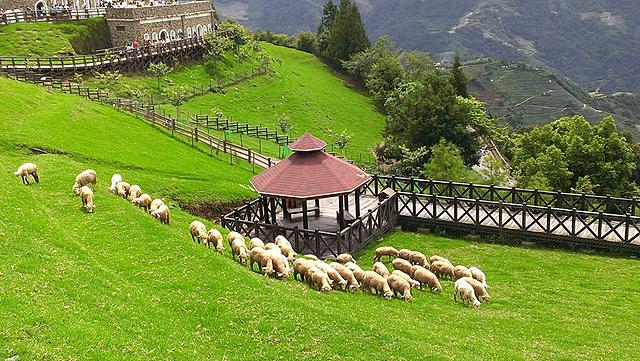

INFO:tensorflow:Restoring parameters from model_ckpt/model.ckpt-811030
a herd of sheep grazing on a lush green hillside


In [17]:
tf.reset_default_graph()  # reset graph for cnn model
U = cPickle.load(open('dataset/U.pkl', 'rb'))  # PCA transforming matrix
vgg = PretrainedCNN('pre_trained/vgg16_mat.pkl')
demo('images/Sheep.jpg', vgg, U, enc_map, dec_map, hparams)

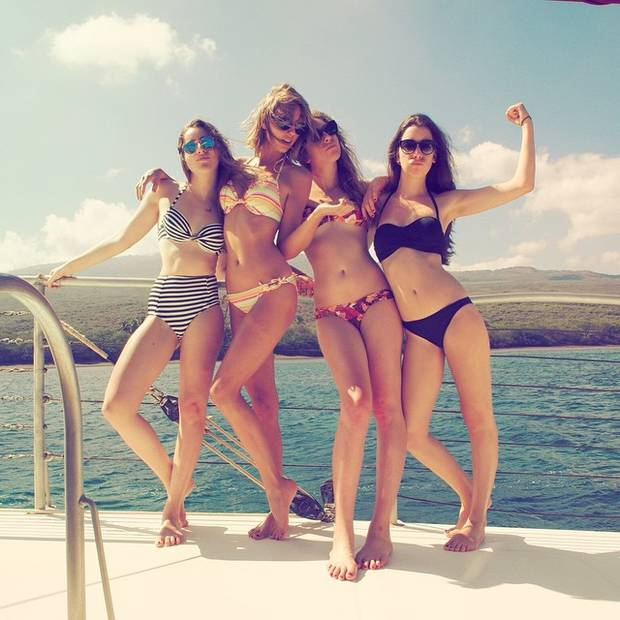

INFO:tensorflow:Restoring parameters from model_ckpt/model.ckpt-811030
a couple of women standing on top of a sandy beach


In [18]:
tf.reset_default_graph()  # reset graph for cnn model
U = cPickle.load(open('dataset/U.pkl', 'rb'))  # PCA transforming matrix
vgg = PretrainedCNN('pre_trained/vgg16_mat.pkl')
demo('images/Taylor.jpg', vgg, U, enc_map, dec_map, hparams)

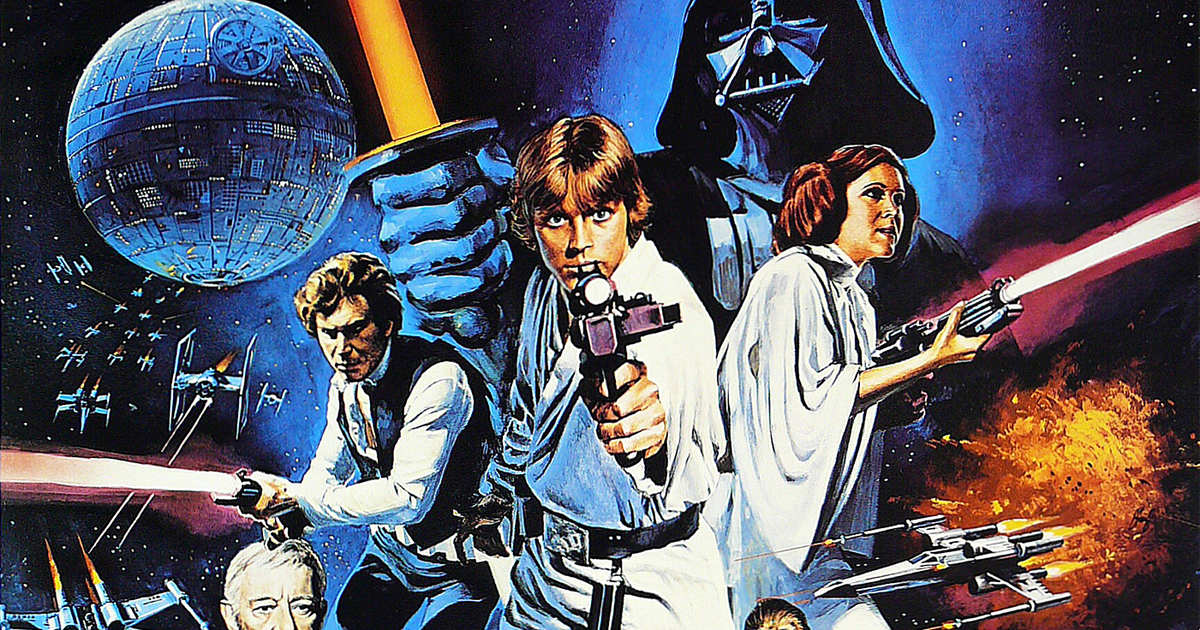

INFO:tensorflow:Restoring parameters from model_ckpt/model.ckpt-811030
a group of people sitting around a table


In [19]:
tf.reset_default_graph()  # reset graph for cnn model
U = cPickle.load(open('dataset/U.pkl', 'rb'))  # PCA transforming matrix
vgg = PretrainedCNN('pre_trained/vgg16_mat.pkl')
demo('images/Star_Wars.png', vgg, U, enc_map, dec_map, hparams)